In [1]:
# Preprocessing module for time series data
# loads data from ../data/raw/ and saves processed data to ../data/processed/
import os
import pandas as pd
import yaml

def load_data(data_dir: str) -> pd.DataFrame:
    ''' Load data from CSV files in the given directory.
    Each CSV file corresponds to a different feature and contains time series data for multiple stations.
    The function reads each CSV file, resamples the data to hourly frequency, and reshapes it into a long format.
    Finally, it concatenates all the data into a single DataFrame with columns: Date, Feature, Station, Value.
    '''
    df = pd.DataFrame()
    for file in os.listdir(data_dir):
        if file.endswith(".csv"):
            print(f"Loading file: {file}")

            feature = file.replace(".csv", "")
            temp_df = pd.read_csv(os.path.join(data_dir, file), parse_dates=True, sep=",", index_col=0)
            temp_df.index = pd.to_datetime(temp_df.index, errors='coerce')

            if temp_df.index.tz is not None:
                temp_df.index = temp_df.index.tz_convert(None)  # Remove timezone if present

            print(f"The length of {feature}-DataFrame is {len(temp_df)}, before resampling")
            temp_df.columns = [str(col) for col in temp_df.columns]
            temp_df = temp_df.asfreq('h')
            temp_df = temp_df.reindex()

            temp_df["Feature"] = feature
            temp_df["Date"] = temp_df.index
            print(f"The length of {feature}-DataFrame is {len(temp_df)}, after resampling")
            temp_df = temp_df.melt(id_vars=["Date", "Feature"], var_name='Station', value_name='Value')
            df = pd.concat([df, temp_df], axis=0)

            df = df.reset_index(drop=True)
    df = transform_data(df)
    return df

def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    ''' Transform the loaded data by handling missing values and converting temperature to Kelvin.
    '''
    # Handle temperature conversion to Kelvin
    temp_mask = df['Feature'].str.contains('temperature', case=False, na=False)
    df.loc[temp_mask, 'Value'] = df.loc[temp_mask, 'Value'] + 273.15
    #df.loc[temp_mask, 'Value'] = df.loc[temp_mask, 'Value'].clip(lower=0, upper=360)

    # Handle direction values to be within 0-360
    dir_mask = df['Feature'].str.contains('direction', case=False, na=False)
    df.loc[dir_mask, 'Value'] = df.loc[dir_mask, 'Value'].clip(lower=0, upper=360)

    return df

def save_data(df: pd.DataFrame, output_path: str):
    ''' Save the processed DataFrame to a CSV file.
    '''
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    df.to_csv(output_path, index=False)
    print(f"Processed data saved to {output_path}")

def preprocess_data(input_dir: str, output_path: str):
    ''' Main function to load, process, and save the data.
    '''
    df = load_data(input_dir)
    save_data(df, output_path)

def main():
    with open("../params.yaml", 'r') as file:
        params = yaml.safe_load(file)

    input_dir_org = params['raw']['dir']['org']
    input_dir_ref = params['raw']['dir']['ref']
    output_path_org = params['preproc']['dir']['org'] + '/processed_org.csv'
    output_path_ref = params['preproc']['dir']['ref'] + '/processed_ref.csv'

    preprocess_data(input_dir_org, output_path_org)
    preprocess_data(input_dir_ref, output_path_ref)
    print("Preprocessing completed.")
""" if __name__ == "__main__":
    main() """

' if __name__ == "__main__":\n    main() '

In [1]:
import os
import polars as pl
import pandas as pd
import yaml
import numpy as np

def load_data(data_dir: str, data_file: str) -> pl.DataFrame:
    ''' Load and preprocess data from the specified directory.
    '''
    df = pl.read_csv(os.path.join(data_dir, data_file), try_parse_dates=True)
    return df

def save_data(df: pl.DataFrame, output_dir: str, output_file: str):
    ''' Save the processed DataFrame to a CSV file.
    '''
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    output_path = os.path.join(output_dir, output_file)
    df.write_csv(output_path)
    print(f"Processed data saved to {output_path}")

def apply_missing_pattern(df_org: pl.DataFrame, df_ref: pl.DataFrame) -> tuple[pl.DataFrame, pl.DataFrame]:
    ''' Apply the missing data pattern from the original data to the reference data.
    '''
    df_missing = df_org.with_columns(pl.col("Value").is_null().alias("missing"))
    df_missing_features = dict(df_missing.partition_by("Feature", as_dict=True))
    df_missing_stations = dict(df_missing.partition_by("Station", as_dict=True))
    stations = df_org["Station"].unique().to_list()
    features = df_org["Feature"].unique().to_list()

    for f in features:
        print(f"Processing feature: {f}")
        feat_df = df_missing_features[(f,)].pivot(index="Date", on="Station", values="missing")
        # if a station is missing append it with mean missing pattern of other stations
        cols = feat_df.columns
        cols.remove("Date")
        cols.remove("ZAC")
        print(cols)
        feat_df = feat_df.with_columns(mean_missing=pl.mean_horizontal(cols))
        for s in stations:
            if s not in feat_df.columns:
                feat_df = feat_df.with_columns(pl.col("mean_missing").alias(s))
        df_missing_features[(f,)] = feat_df.drop("mean_missing").unpivot(index=["Date"], variable_name="Station", value_name="missing").with_columns(pl.lit(f).alias("Feature"))

    for s in stations:
        print(f"Processing station: {s}")
        stat_df = df_missing_stations[(s,)].pivot(index="Date", on="Feature", values="missing")
        # if a feature is missing append it with mean missing pattern of other features
        cols = stat_df.columns
        cols.remove("Date")
        print(cols)
        stat_df = stat_df.with_columns(mean_missing=pl.mean_horizontal(cols))
        for f in features:
            if f not in stat_df.columns:
                stat_df = stat_df.with_columns(pl.col("mean_missing").alias(f))
        df_missing_stations[(s,)] = stat_df.drop("mean_missing").unpivot(index=["Date"], variable_name="Feature", value_name="missing").with_columns(pl.lit(s).alias("Station"))


    stat_feat_list = ['{"' + s + '","' + f + '"}' for s in stations for f in features]
    columns_list = df_missing.pivot(index="Date", on=["Station", "Feature"], values="missing").columns

    for s_f in stat_feat_list:
        if s_f not in columns_list:
            station = s_f.split('","')[0][2:]
            feature = s_f.split('","')[1][:-2]
            print(f"Adding missing combination: {s_f}")
            feat_missing = df_missing_features[(feature,)].filter(pl.col("Station") == station).with_columns(pl.col("missing").alias("feat_missing")).drop("missing")
            stat_missing = df_missing_stations[(station,)].filter(pl.col("Feature") == feature).with_columns(pl.col("missing").alias("stat_missing")).drop("missing")
            mean_missing = pl.concat([feat_missing, stat_missing], how="align").with_columns(np.rint(pl.mean_horizontal(["feat_missing", "stat_missing"])).cast(pl.Boolean).alias("missing")).drop(["feat_missing", "stat_missing"])
            df_missing = pl.concat([df_missing, mean_missing], how="align")

    df_ref = df_ref.join(df_missing, on=["Date", "Station", "Feature"], how="left")
    df_ref = df_ref.with_columns(
        pl.when(~pl.col("missing"))
        .then(pl.col("Value"))
        .otherwise(pl.lit(None).cast(pl.Float64))
        .alias("Value_missing")
    ).drop("Value_right")
    return df_missing, df_ref
    

def clip_data(df_org: pl.DataFrame, df_ref: pl.DataFrame, method: str) -> tuple[pl.DataFrame, pl.DataFrame]:
    ''' Clip the values in the DataFrames based on the specified method.
    '''
    if method == "default":
        # determine the index range of the reference data and apply it to both dataframes
        start_idx = df_ref['Date'].min()
        end_idx = df_ref['Date'].max()
        df_org = df_org.filter((df_org['Date'] >= start_idx) & (df_org['Date'] <= end_idx))
        df_ref = df_ref.filter((df_ref['Date'] >= start_idx) & (df_ref['Date'] <= end_idx))

    elif method == "moderate":
        pass  # No clipping applied
    elif method == "aggressive":
        pass  # No clipping applied
    return df_org, df_ref

def main():
    with open("../params.yaml", 'r') as file:
        params = yaml.safe_load(file)

    input_dir = params['preproc']['dir']
    data_file_org = params['preproc']['files']['org']
    data_file_ref = params['preproc']['files']['ref']

    output_dir = params['prepared']['dir']
    output_file_org = params['prepared']['files']['org']
    output_file_ref = params['prepared']['files']['ref']

    clip_method = params['prepared']['clip']
    df_org: pl.DataFrame = load_data(input_dir, data_file_org)
    df_ref: pl.DataFrame = load_data(input_dir, data_file_ref)
    df_org, df_ref = clip_data(df_org, df_ref, clip_method)
    df_org, df_ref = apply_missing_pattern(df_org, df_ref)
    save_data(df_ref, output_dir, output_file_org)
    save_data(df_org, output_dir, output_file_ref)
    print("Data preparation completed.")

if __name__ == "__main__":
    main()

KeyError: 'preproc'

In [4]:
df_org = load_data("../data/02_preproc", "processed_org.csv")
df_ref = load_data("../data/02_preproc", "processed_ref.csv")

In [69]:
df_org, df_ref = clip_data(df_org, df_ref, "default")

In [ ]:
df_missing = df_org.with_columns(pl.col("Value").is_null().alias("missing"))
df_missing_features = dict(df_missing.partition_by("Feature", as_dict=True))
df_missing_stations = dict(df_missing.partition_by("Station", as_dict=True))
stations = df_org["Station"].unique().to_list()
features = df_org["Feature"].unique().to_list()

for f in features:
    print(f"Processing feature: {f}")
    feat_df = df_missing_features[(f,)].pivot(index="Date", on="Station", values="missing")
    # if a station is missing append it with mean missing pattern of other stations
    cols = feat_df.columns
    cols.remove("Date")
    cols.remove("ZAC")
    print(cols)
    feat_df = feat_df.with_columns(mean_missing=pl.mean_horizontal(cols))
    for s in stations:
        if s not in feat_df.columns:
            feat_df = feat_df.with_columns(pl.col("mean_missing").alias(s))
    df_missing_features[(f,)] = feat_df.drop("mean_missing").unpivot(index=["Date"], variable_name="Station", value_name="missing").with_columns(pl.lit(f).alias("Feature"))

for s in stations:
    print(f"Processing station: {s}")
    stat_df = df_missing_stations[(s,)].pivot(index="Date", on="Feature", values="missing")
    # if a feature is missing append it with mean missing pattern of other features
    cols = stat_df.columns
    cols.remove("Date")
    print(cols)
    stat_df = stat_df.with_columns(mean_missing=pl.mean_horizontal(cols))
    for f in features:
        if f not in stat_df.columns:
            stat_df = stat_df.with_columns(pl.col("mean_missing").alias(f))
    df_missing_stations[(s,)] = stat_df.drop("mean_missing").unpivot(index=["Date"], variable_name="Feature", value_name="missing").with_columns(pl.lit(s).alias("Station"))


stat_feat_list = ['{"' + s + '","' + f + '"}' for s in stations for f in features]
columns_list = df_missing.pivot(index="Date", on=["Station", "Feature"], values="missing").columns

for s_f in stat_feat_list:
    if s_f not in columns_list:
        station = s_f.split('","')[0][2:]
        feature = s_f.split('","')[1][:-2]
        print(f"Adding missing combination: {s_f}")
        feat_missing = df_missing_features[(feature,)].filter(pl.col("Station") == station).with_columns(pl.col("missing").alias("feat_missing")).drop("missing")
        stat_missing = df_missing_stations[(station,)].filter(pl.col("Feature") == feature).with_columns(pl.col("missing").alias("stat_missing")).drop("missing")
        mean_missing = pl.concat([feat_missing, stat_missing], how="align").with_columns(np.rint(pl.mean_horizontal(["feat_missing", "stat_missing"])).cast(pl.Boolean).alias("missing")).drop(["feat_missing", "stat_missing"])
        df_missing = pl.concat([df_missing, mean_missing], how="align")


# replace station names of df_missing to df_ref
stations_ref = df_ref["Station"].unique().to_list()
stations_org = df_org["Station"].unique().to_list()
station_map = {key: value for key, value in zip(stations_org, stations_ref)}
df_missing = df_missing.with_columns(pl.col("Station").map_elements(lambda s: station_map.get(s, None)))

df_ref = df_ref.join(df_missing, on=["Date", "Station", "Feature"], how="left")
# create a column that keeps Value only when missing is False, otherwise set to null
df_ref = df_ref.with_columns(
	pl.when(~pl.col("missing"))
	  .then(pl.col("Value"))
	  .otherwise(pl.lit(None).cast(pl.Float64))
	  .alias("Value_missing")
).drop("Value_right")




Processing feature: Wind_speed
['M2', 'M3', 'M8', 'M6', 'M7', 'AP1', 'AP2', 'AP3']
Processing feature: Wind_direction
['M2', 'M3', 'M8', 'M6', 'M7', 'AP1', 'AP2', 'AP3']
Processing feature: Air_pressure
['M6', 'AP1', 'AP2', 'AP3', 'DAN']
Processing feature: Relative_humidity
['M2', 'M3', 'M6', 'M7', 'AP1', 'AP2', 'AP3']
Processing feature: Air_temperature
['M2', 'M3', 'M8', 'M6', 'M7', 'AP1', 'AP2', 'AP3']
Processing station: DAN
['Air_pressure']
Processing station: AP2
['Air_pressure', 'Air_temperature', 'Relative_humidity', 'Wind_direction', 'Wind_speed']
Processing station: M7
['Air_temperature', 'Relative_humidity', 'Wind_direction', 'Wind_speed']
Processing station: M6
['Air_pressure', 'Air_temperature', 'Relative_humidity', 'Wind_direction', 'Wind_speed']
Processing station: ZAC
['Air_pressure', 'Air_temperature', 'Relative_humidity', 'Wind_direction', 'Wind_speed']
Processing station: M3
['Air_temperature', 'Relative_humidity', 'Wind_direction', 'Wind_speed']
Processing station:

In [6]:
df_missing

Date,Feature,Station,Value,missing
datetime[μs],str,str,f64,bool
1995-08-17 00:00:00,"""Air_pressure""","""20212_KLAGENFURT-FLUGHAFEN""",null,true
1995-08-17 00:00:00,"""Air_pressure""","""3202_LINZ-STADT""",null,true
1995-08-17 00:00:00,"""Air_pressure""","""5904_WIEN-HOHE WARTE""",null,true
1995-08-17 00:00:00,"""Air_pressure""","""5316_AMSTETTEN""",null,true
1995-08-17 00:00:00,"""Air_pressure""","""11505_REUTTE""",null,true
…,…,…,…,…
2019-12-31 23:00:00,"""Wind_speed""","""4305_ZWERNDORF""",null,true
2019-12-31 23:00:00,"""Wind_speed""","""12504_BISCHOFSHOFEN""",null,true
2019-12-31 23:00:00,"""Wind_speed""","""5925_WIEN-INNERE STADT""",null,true


In [ ]:
# replace station names of df_missing to df_ref
stations_ref = df_ref["Station"].unique().to_list()
stations_org = df_org["Station"].unique().to_list()
station_map = {key: value for key, value in zip(stations_org, stations_ref)}
df_missing = df_missing.with_columns(pl.col("Station").map_elements(lambda s: station_map.get(s, None)))

df_ref = df_ref.join(df_missing, on=["Date", "Station", "Feature"], how="left")
# create a column that keeps Value only when missing is False, otherwise set to null
df_ref = df_ref.with_columns(
	pl.when(~pl.col("missing"))
	  .then(pl.col("Value"))
	  .otherwise(pl.lit(None).cast(pl.Float64))
	  .alias("Value_missing")
).drop("Value_right")

In [256]:
zip(stations_org, stations_ref)

In [257]:
station_map.get("ZAC")

'20212_KLAGENFURT-FLUGHAFEN'

In [258]:
df_missing

Date,Feature,Station,Value,missing
datetime[μs],str,str,f64,bool
2008-08-05 00:00:00,"""Air_pressure""","""5904_WIEN-HOHE WARTE""",945.636549,false
2008-08-05 00:00:00,"""Air_pressure""","""5316_AMSTETTEN""",null,true
2008-08-05 00:00:00,"""Air_pressure""","""3202_LINZ-STADT""",null,true
2008-08-05 00:00:00,"""Air_pressure""","""4305_ZWERNDORF""",null,true
2008-08-05 00:00:00,"""Air_pressure""","""12504_BISCHOFSHOFEN""",null,true
…,…,…,…,…
2018-08-04 23:00:00,"""Wind_speed""","""11505_REUTTE""",0.81,false
2018-08-04 23:00:00,"""Wind_speed""","""7604_WR.NEUSTADT/FLUGPLATZ""",null,true
2018-08-04 23:00:00,"""Wind_speed""","""5972_GROSS-ENZERSDORF""",0.55,false


In [ ]:

df_ref

Date,Feature,Station,Value,missing,Value_missing
datetime[μs],str,str,f64,bool,f64
2008-08-05 00:00:00,"""Wind_direction""","""5904_WIEN-HOHE WARTE""",270.0,true,null
2008-08-05 01:00:00,"""Wind_direction""","""5904_WIEN-HOHE WARTE""",263.0,true,null
2008-08-05 02:00:00,"""Wind_direction""","""5904_WIEN-HOHE WARTE""",263.0,true,null
2008-08-05 03:00:00,"""Wind_direction""","""5904_WIEN-HOHE WARTE""",271.0,true,null
2008-08-05 04:00:00,"""Wind_direction""","""5904_WIEN-HOHE WARTE""",268.0,true,null
…,…,…,…,…,…
2018-08-04 19:00:00,"""Wind_speed""","""5972_GROSS-ENZERSDORF""",1.3,false,1.3
2018-08-04 20:00:00,"""Wind_speed""","""5972_GROSS-ENZERSDORF""",1.8,false,1.8
2018-08-04 21:00:00,"""Wind_speed""","""5972_GROSS-ENZERSDORF""",2.1,false,2.1


In [ ]:
df_missing.pivot(index="Date", on=["Station", "Feature"], values="missing").columns


['Date',
 '{"ZAC","Air_pressure"}',
 '{"M6","Air_pressure"}',
 '{"AP1","Air_pressure"}',
 '{"AP2","Air_pressure"}',
 '{"AP3","Air_pressure"}',
 '{"DAN","Air_pressure"}',
 '{"ZAC","Air_temperature"}',
 '{"M2","Air_temperature"}',
 '{"M3","Air_temperature"}',
 '{"M8","Air_temperature"}',
 '{"M6","Air_temperature"}',
 '{"M7","Air_temperature"}',
 '{"AP1","Air_temperature"}',
 '{"AP2","Air_temperature"}',
 '{"AP3","Air_temperature"}',
 '{"ZAC","Relative_humidity"}',
 '{"M2","Relative_humidity"}',
 '{"M3","Relative_humidity"}',
 '{"M6","Relative_humidity"}',
 '{"M7","Relative_humidity"}',
 '{"AP1","Relative_humidity"}',
 '{"AP2","Relative_humidity"}',
 '{"AP3","Relative_humidity"}',
 '{"ZAC","Wind_direction"}',
 '{"M2","Wind_direction"}',
 '{"M3","Wind_direction"}',
 '{"M8","Wind_direction"}',
 '{"M6","Wind_direction"}',
 '{"M7","Wind_direction"}',
 '{"AP1","Wind_direction"}',
 '{"AP2","Wind_direction"}',
 '{"AP3","Wind_direction"}',
 '{"ZAC","Wind_speed"}',
 '{"M2","Wind_speed"}',
 '{"M3",

In [97]:
AT = df_missing_features[('Air_temperature',)]
AT

Date,Station,missing,Feature
datetime[μs],str,bool,str
2008-08-05 00:00:00,"""ZAC""",false,"""Air_temperature"""
2008-08-05 01:00:00,"""ZAC""",false,"""Air_temperature"""
2008-08-05 02:00:00,"""ZAC""",false,"""Air_temperature"""
2008-08-05 03:00:00,"""ZAC""",false,"""Air_temperature"""
2008-08-05 04:00:00,"""ZAC""",false,"""Air_temperature"""
…,…,…,…
2018-08-04 19:00:00,"""DAN""",null,"""Air_temperature"""
2018-08-04 20:00:00,"""DAN""",null,"""Air_temperature"""
2018-08-04 21:00:00,"""DAN""",null,"""Air_temperature"""


In [33]:
df_ref.pivot(index='Date', on=["Feature", "Station"]).null_count()# / df_ref.pivot(index='Date', on=["Feature", "Station"]).count()*100

Date,"{""Wind_direction"",""5904_WIEN-HOHE WARTE""}","{""Wind_direction"",""5925_WIEN-INNERE STADT""}","{""Wind_direction"",""3202_LINZ-STADT""}","{""Wind_direction"",""4305_ZWERNDORF""}","{""Wind_direction"",""12504_BISCHOFSHOFEN""}","{""Wind_direction"",""20212_KLAGENFURT-FLUGHAFEN""}","{""Wind_direction"",""5316_AMSTETTEN""}","{""Wind_direction"",""11505_REUTTE""}","{""Wind_direction"",""7604_WR.NEUSTADT/FLUGPLATZ""}","{""Wind_direction"",""5972_GROSS-ENZERSDORF""}","{""Relative_humidity"",""5904_WIEN-HOHE WARTE""}","{""Relative_humidity"",""5925_WIEN-INNERE STADT""}","{""Relative_humidity"",""3202_LINZ-STADT""}","{""Relative_humidity"",""4305_ZWERNDORF""}","{""Relative_humidity"",""12504_BISCHOFSHOFEN""}","{""Relative_humidity"",""20212_KLAGENFURT-FLUGHAFEN""}","{""Relative_humidity"",""5316_AMSTETTEN""}","{""Relative_humidity"",""11505_REUTTE""}","{""Relative_humidity"",""7604_WR.NEUSTADT/FLUGPLATZ""}","{""Relative_humidity"",""5972_GROSS-ENZERSDORF""}","{""Air_pressure"",""5904_WIEN-HOHE WARTE""}","{""Air_pressure"",""5925_WIEN-INNERE STADT""}","{""Air_pressure"",""3202_LINZ-STADT""}","{""Air_pressure"",""4305_ZWERNDORF""}","{""Air_pressure"",""12504_BISCHOFSHOFEN""}","{""Air_pressure"",""20212_KLAGENFURT-FLUGHAFEN""}","{""Air_pressure"",""5316_AMSTETTEN""}","{""Air_pressure"",""11505_REUTTE""}","{""Air_pressure"",""7604_WR.NEUSTADT/FLUGPLATZ""}","{""Air_pressure"",""5972_GROSS-ENZERSDORF""}","{""Air_temperature"",""5904_WIEN-HOHE WARTE""}","{""Air_temperature"",""5925_WIEN-INNERE STADT""}","{""Air_temperature"",""3202_LINZ-STADT""}","{""Air_temperature"",""4305_ZWERNDORF""}","{""Air_temperature"",""12504_BISCHOFSHOFEN""}","{""Air_temperature"",""20212_KLAGENFURT-FLUGHAFEN""}","{""Air_temperature"",""5316_AMSTETTEN""}","{""Air_temperature"",""11505_REUTTE""}","{""Air_temperature"",""7604_WR.NEUSTADT/FLUGPLATZ""}","{""Air_temperature"",""5972_GROSS-ENZERSDORF""}","{""Wind_speed"",""5904_WIEN-HOHE WARTE""}","{""Wind_speed"",""5925_WIEN-INNERE STADT""}","{""Wind_speed"",""3202_LINZ-STADT""}","{""Wind_speed"",""4305_ZWERNDORF""}","{""Wind_speed"",""12504_BISCHOFSHOFEN""}","{""Wind_speed"",""20212_KLAGENFURT-FLUGHAFEN""}","{""Wind_speed"",""5316_AMSTETTEN""}","{""Wind_speed"",""11505_REUTTE""}","{""Wind_speed"",""7604_WR.NEUSTADT/FLUGPLATZ""}","{""Wind_speed"",""5972_GROSS-ENZERSDORF""}"
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,16,112,10,6,2,58,59,84,236,5,0,0,1,0,0,20,14,13,4,3,0,3,1,0,0,41,15,13,2,11,0,0,1,0,0,14,15,13,4,3,16,112,10,6,2,58,59,84,230,5


<Axes: >

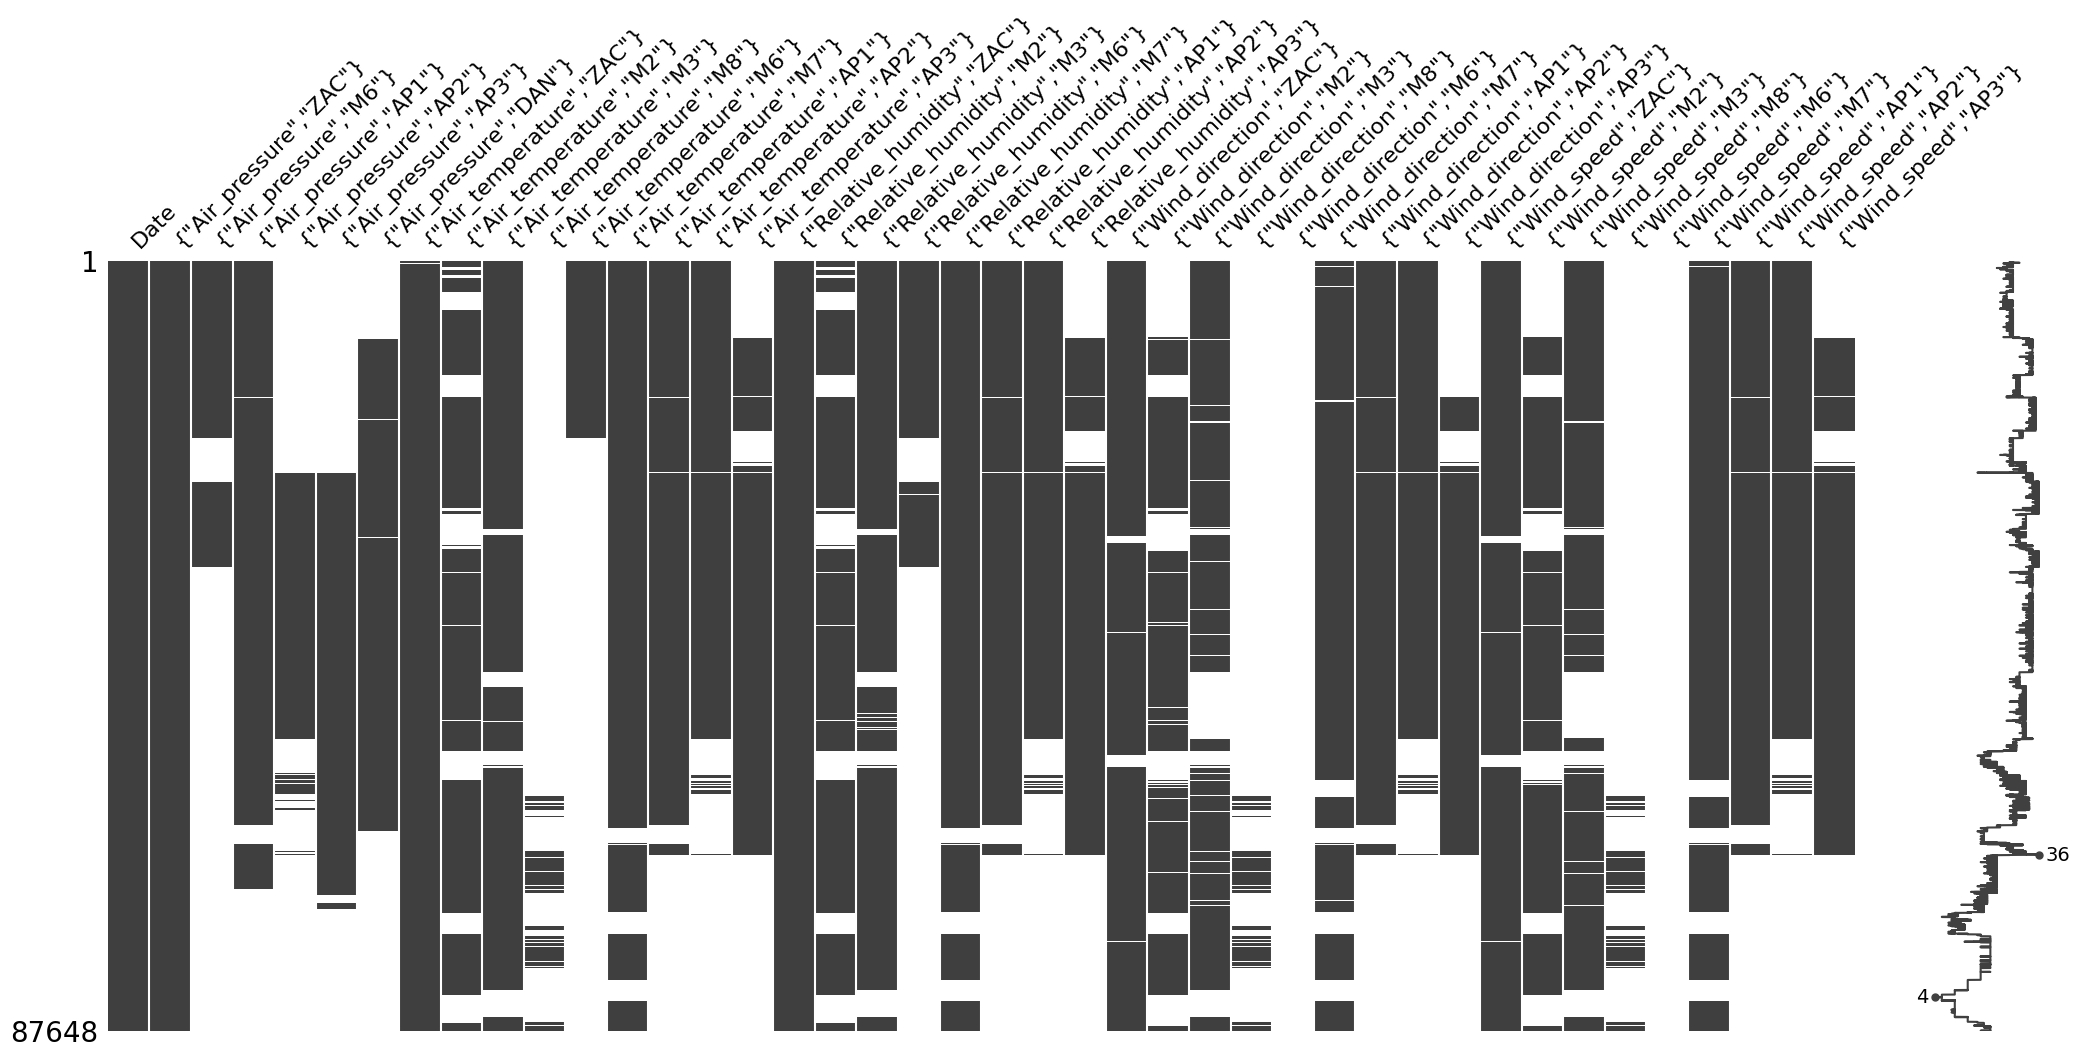

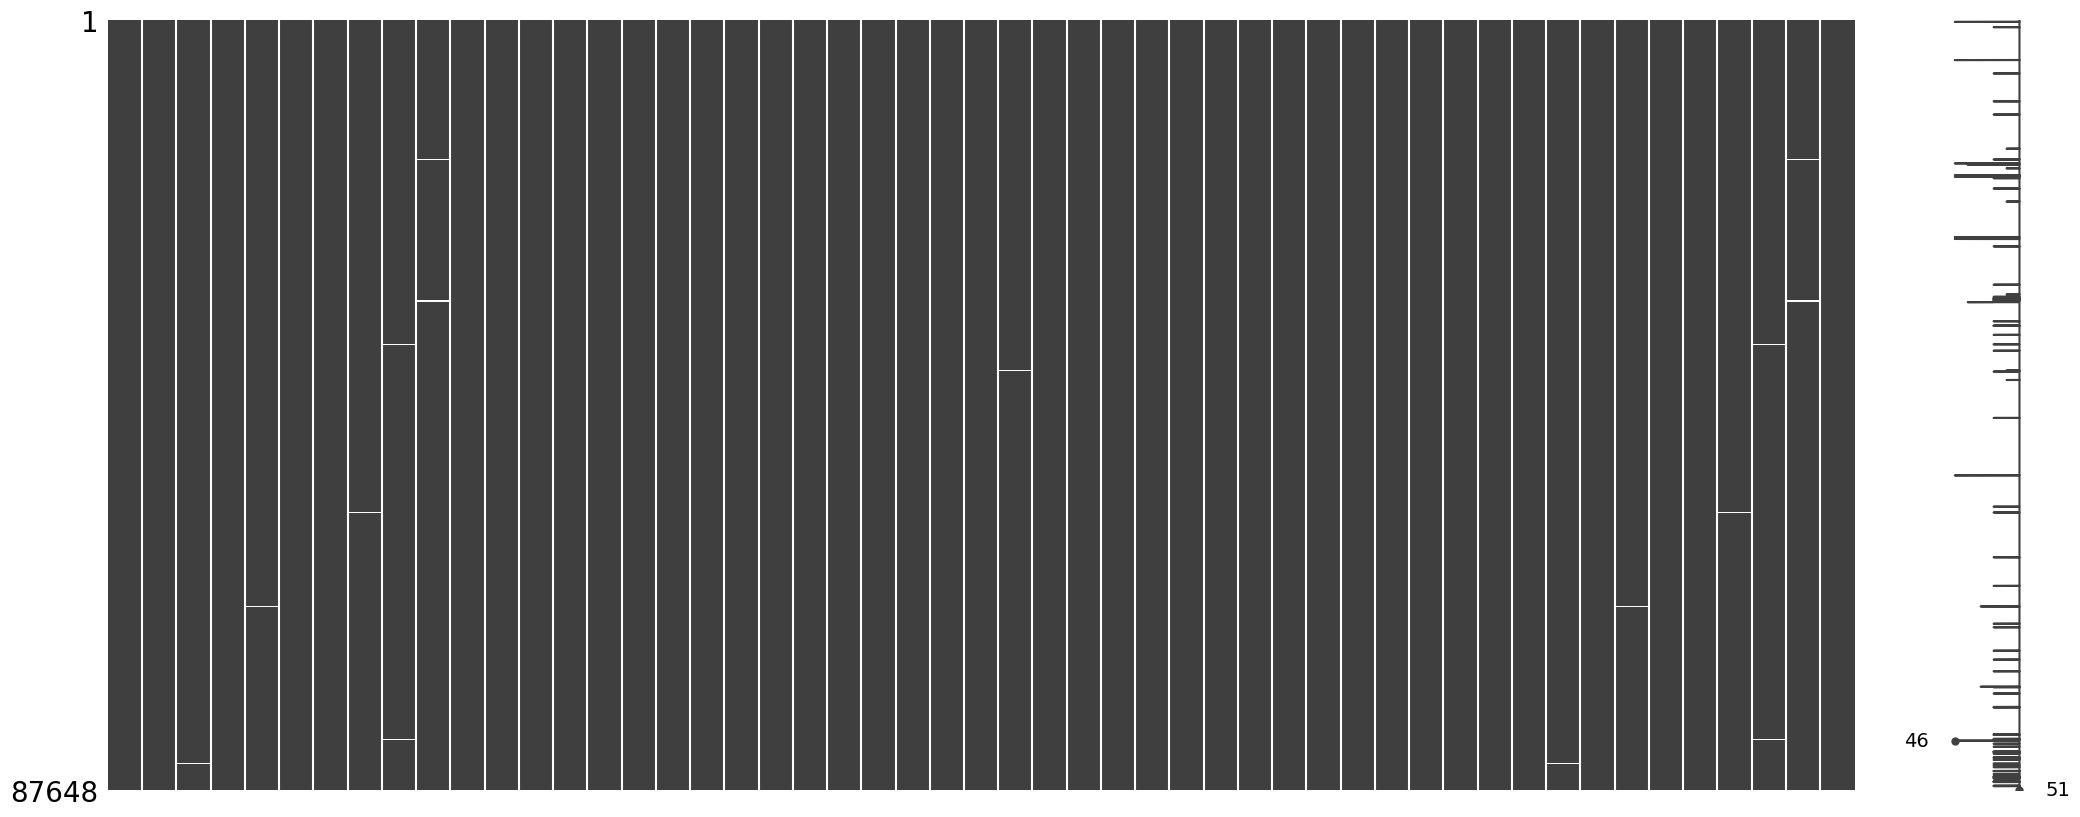

In [8]:
import missingno as msno
msno.matrix(df_org.pivot(index='Date', on=["Feature", "Station"]).to_pandas())
msno.matrix(df_ref.pivot(index='Date', on=["Feature", "Station"]).to_pandas())

In [7]:

start_idx = df_ref['Date'].min()
end_idx = df_ref['Date'].max()
df_org = df_org.filter((df_org['Date'] >= start_idx) & (df_org['Date'] <= end_idx))
df_ref = df_ref.filter((df_ref['Date'] >= start_idx) & (df_ref['Date'] <= end_idx))    

In [9]:
df_org["Date"].describe()

statistic,value
str,str
"""count""","""3593568"""
"""null_count""","""0"""
"""mean""","""2013-08-04 23:30:00"""
"""min""","""2008-08-05 00:00:00"""
"""25%""","""2011-02-04 00:00:00"""
"""50%""","""2013-08-05 00:00:00"""
"""75%""","""2016-02-03 23:00:00"""
"""max""","""2018-08-04 23:00:00"""


In [16]:
df_ref = df_ref.join(df_org.select(["Date", "Station", "Value"]).with_columns([
        pl.col("Value").is_null().alias("is_missing")
    ]), on=["Date", "Station"], how="left")


In [34]:
pl.DataFrame({"Station": df_org["Station"].unique(), "Reference": df_ref["Station"].unique()})

Station,Reference
str,str
"""AP1""","""20212_KLAGENFURT-FLUGHAFEN"""
"""AP3""","""12504_BISCHOFSHOFEN"""
"""M8""","""3202_LINZ-STADT"""
"""M3""","""5904_WIEN-HOHE WARTE"""
"""M2""","""4305_ZWERNDORF"""
"""AP2""","""5972_GROSS-ENZERSDORF"""
"""DAN""","""11505_REUTTE"""
"""M7""","""5925_WIEN-INNERE STADT"""
"""M6""","""7604_WR.NEUSTADT/FLUGPLATZ"""


In [9]:
import polars as pl
from typing import Dict, List

def analyze_missingness(df: pl.DataFrame) -> Dict[str, Dict]:
    """
    Analyzes the missingness of each feature in a Polars DataFrame,
    excluding blocks that start at the first observation or end at the last observation.

    Args:
        df: Polars DataFrame

    Returns:
        dict: A dictionary where keys are column names and values are dictionaries containing:
              - "missing_values": total number of missing values
              - "missing_blocks": number of contiguous missing blocks (excluding edge blocks)
              - "block_sizes": list of sizes of each missing block (excluding edge blocks)
    """
    result = {}
    for col in df.columns:
        if col in ["Date"]:
            continue
        s = df[col]
        is_null = s.is_null()

        # Total missing values
        missing_values = is_null.sum()

        # Convert boolean mask to integer for diff()
        is_null_int = is_null.cast(pl.Int8)

        # Find the start and end of each block of True (null) values
        diff = is_null_int.diff()
        starts = (diff == 1).arg_true()
        ends = (diff == -1).arg_true()

        # Adjust for edge cases: exclude blocks at the start or end
        block_starts = []
        block_ends = []

        for start, end in zip(starts, ends):
            if start > 0 and end < len(is_null) - 1:
                block_starts.append(start)
                block_ends.append(end)

        # Calculate block sizes
        block_sizes = [(block_ends[i] - block_starts[i] + 1) for i in range(len(block_starts))]
        missing_blocks = len(block_sizes)

        result[col] = {
            "missing_values": missing_values,
            "missing_blocks": missing_blocks,
            "block_sizes": block_sizes,
        }
    return result


In [15]:
df_org.with_columns(pl.col("Value").is_null().alias("is_null"))

Date,Feature,Station,Value,is_null
datetime[μs],str,str,f64,bool
2003-08-05 00:00:00,"""Air_pressure""","""ZAC""",1007.1,false
2003-08-05 01:00:00,"""Air_pressure""","""ZAC""",1007.0,false
2003-08-05 02:00:00,"""Air_pressure""","""ZAC""",1006.8,false
2003-08-05 03:00:00,"""Air_pressure""","""ZAC""",1007.1,false
2003-08-05 04:00:00,"""Air_pressure""","""ZAC""",1007.3,false
…,…,…,…,…
2018-08-04 19:00:00,"""Wind_speed""","""AP3""",null,true
2018-08-04 20:00:00,"""Wind_speed""","""AP3""",null,true
2018-08-04 21:00:00,"""Wind_speed""","""AP3""",null,true


In [ ]:
df_org.with_columns(pl.col("Value").is_null().alias("is_null")).pivot(index="Date", on=["Feature", "Station"], values="is_null")

/tmp/ipykernel_15793/2792253263.py:1: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  data.with_columns(pl.col("Value").is_null().alias("is_null")).pivot(index="Date", columns=["Feature", "Station"], values="is_null")


Date,"{""Wind_speed"",""ZAC""}","{""Wind_speed"",""M2""}","{""Wind_speed"",""M3""}","{""Wind_speed"",""M8""}","{""Wind_speed"",""M6""}","{""Wind_speed"",""M7""}","{""Wind_speed"",""AP1""}","{""Wind_speed"",""AP2""}","{""Wind_speed"",""AP3""}","{""Air_pressure"",""ZAC""}","{""Air_pressure"",""M6""}","{""Air_pressure"",""AP1""}","{""Air_pressure"",""AP2""}","{""Air_pressure"",""AP3""}","{""Air_pressure"",""DAN""}","{""Relative_humidity"",""ZAC""}","{""Relative_humidity"",""M2""}","{""Relative_humidity"",""M3""}","{""Relative_humidity"",""M6""}","{""Relative_humidity"",""M7""}","{""Relative_humidity"",""AP1""}","{""Relative_humidity"",""AP2""}","{""Relative_humidity"",""AP3""}","{""Air_temperature"",""ZAC""}","{""Air_temperature"",""M2""}","{""Air_temperature"",""M3""}","{""Air_temperature"",""M8""}","{""Air_temperature"",""M6""}","{""Air_temperature"",""M7""}","{""Air_temperature"",""AP1""}","{""Air_temperature"",""AP2""}","{""Air_temperature"",""AP3""}","{""Wind_direction"",""ZAC""}","{""Wind_direction"",""M2""}","{""Wind_direction"",""M3""}","{""Wind_direction"",""M8""}","{""Wind_direction"",""M6""}","{""Wind_direction"",""M7""}","{""Wind_direction"",""AP1""}","{""Wind_direction"",""AP2""}","{""Wind_direction"",""AP3""}"
datetime[μs],bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
1995-08-17 00:00:00,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true
1995-08-17 01:00:00,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true
1995-08-17 02:00:00,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true
1995-08-17 03:00:00,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true
1995-08-17 04:00:00,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2019-12-31 19:00:00,false,true,true,true,true,true,true,true,true,false,true,true,true,true,true,false,true,true,true,true,true,true,true,false,true,true,true,true,true,true,true,true,false,true,true,true,true,true,true,true,true
2019-12-31 20:00:00,false,true,true,true,true,true,true,true,true,false,true,true,true,true,true,false,true,true,true,true,true,true,true,false,true,true,true,true,true,true,true,true,false,true,true,true,true,true,true,true,true
2019-12-31 21:00:00,false,true,true,true,true,true,true,true,true,false,true,true,true,true,true,false,true,true,true,true,true,true,true,false,true,true,true,true,true,true,true,true,false,true,true,true,true,true,true,true,true


In [27]:
data = load_data("../data/02_preproc", "processed_org.csv")

data_dicts = data.partition_by("Feature", "Station", as_dict=True)

index_df = pd.DataFrame(columns=["Station", "Feature", "First_Non_NaN", "Last_Non_NaN"])
for (feature, station), df in data_dicts.items():
    df = df.to_pandas()
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df.drop(columns=["Feature", "Station"])
    
    # Get the index of the first non-NaN value in the "Value" column
    idx_min = df.first_valid_index()
    idx_max = df.last_valid_index()
    
    temp_df = pd.DataFrame({"Station": [station], "Feature": [feature], "First_Non_NaN": [idx_min], "Last_Non_NaN": [idx_max]})
    index_df = pd.concat([index_df, temp_df], axis=0)
    index_df = index_df.reset_index(drop=True)
    


In [28]:
index_df

,Station,Feature,First_Non_NaN,Last_Non_NaN
0,ZAC,Wind_speed,1995-08-18 00:00:00,2019-12-31 23:00:00
1,M2,Wind_speed,2003-08-05 00:00:00,2018-10-15 04:00:00
2,M3,Wind_speed,2003-08-26 19:00:00,2018-10-06 03:00:00
3,M8,Wind_speed,2015-07-16 21:00:00,2018-09-23 22:00:00
4,M6,Wind_speed,2006-08-03 00:00:00,2008-08-13 21:00:00
5,M7,Wind_speed,2008-03-21 16:00:00,2018-09-18 09:00:00
6,AP1,Wind_speed,2008-03-30 00:00:00,2016-04-21 23:00:00
7,AP2,Wind_speed,2008-04-01 00:00:00,2016-04-20 23:00:00
8,AP3,Wind_speed,2009-08-06 00:00:00,2016-04-22 23:00:00
9,ZAC,Air_pressure,1995-08-17 18:00:00,2019-12-31 23:00:00


In [ ]:
import altair as alt
data.plot.line(x="Date", y="Value", color="Station", column="Feature")#.pivot(values="Value", index="Date", on="Station")


In [51]:
data.partition_by("Feature", "Station", as_dict=True)

{('Wind_speed',
  'ZAC'): shape: (213_672, 4)
 ┌─────────────────────┬────────────┬─────────┬──────────┐
 │ Date                ┆ Feature    ┆ Station ┆ Value    │
 │ ---                 ┆ ---        ┆ ---     ┆ ---      │
 │ datetime[μs]        ┆ str        ┆ str     ┆ f64      │
 ╞═════════════════════╪════════════╪═════════╪══════════╡
 │ 1995-08-17 00:00:00 ┆ Wind_speed ┆ ZAC     ┆ null     │
 │ 1995-08-17 01:00:00 ┆ Wind_speed ┆ ZAC     ┆ null     │
 │ 1995-08-17 02:00:00 ┆ Wind_speed ┆ ZAC     ┆ null     │
 │ 1995-08-17 03:00:00 ┆ Wind_speed ┆ ZAC     ┆ null     │
 │ 1995-08-17 04:00:00 ┆ Wind_speed ┆ ZAC     ┆ null     │
 │ …                   ┆ …          ┆ …       ┆ …        │
 │ 2019-12-31 19:00:00 ┆ Wind_speed ┆ ZAC     ┆ 3.418333 │
 │ 2019-12-31 20:00:00 ┆ Wind_speed ┆ ZAC     ┆ 2.121667 │
 │ 2019-12-31 21:00:00 ┆ Wind_speed ┆ ZAC     ┆ 1.866667 │
 │ 2019-12-31 22:00:00 ┆ Wind_speed ┆ ZAC     ┆ 0.94     │
 │ 2019-12-31 23:00:00 ┆ Wind_speed ┆ ZAC     ┆ 0.726667 │
 └────────

In [2]:
df_org = load_data("../data/03_prepared", "prepared_org.csv")
df_ref = load_data("../data/03_prepared", "prepared_ref.csv")

# test resampling option

In [9]:
df_org

Date,Feature,Station,Value,missing
datetime[μs],str,str,f64,bool
2008-08-05 00:00:00,"""Air_pressure""","""5972_GROSS-ENZERSDORF""",945.636549,false
2008-08-05 00:00:00,"""Air_pressure""","""5316_AMSTETTEN""",null,true
2008-08-05 00:00:00,"""Air_pressure""","""11505_REUTTE""",null,true
2008-08-05 00:00:00,"""Air_pressure""","""4305_ZWERNDORF""",null,false
2008-08-05 00:00:00,"""Air_pressure""","""12504_BISCHOFSHOFEN""",null,false
…,…,…,…,…
2018-08-04 23:00:00,"""Wind_speed""","""12504_BISCHOFSHOFEN""",0.81,false
2018-08-04 23:00:00,"""Wind_speed""","""7604_WR.NEUSTADT/FLUGPLATZ""",null,true
2018-08-04 23:00:00,"""Wind_speed""","""5925_WIEN-INNERE""",0.55,false


In [13]:
def resample_df(input_df: pl.DataFrame, freq: str) -> pl.DataFrame:
        """Resample the DataFrame to the specified frequency."""
        input_df = input_df.sort("Date")
        df_resampled = input_df.group_by_dynamic(index_column="Date", every=freq).agg([
            pl.col("Value").mean().alias("Value"),
            pl.col("Station").alias("Station"),
            pl.col("Feature").alias("Feature")
        ])
        return df_resampled

In [14]:
df_org_resampled = resample_df(df_org, '1d')

In [15]:
df_org_resampled

Date,Value,Station,Feature
datetime[μs],f64,list[str],list[str]
2008-08-05 00:00:00,235.977539,"[""5972_GROSS-ENZERSDORF"", ""5316_AMSTETTEN"", … ""3202_LINZ-STADT""]","[""Air_pressure"", ""Air_pressure"", … ""Wind_speed""]"
2008-08-06 00:00:00,236.32121,"[""5972_GROSS-ENZERSDORF"", ""5316_AMSTETTEN"", … ""3202_LINZ-STADT""]","[""Air_pressure"", ""Air_pressure"", … ""Wind_speed""]"
2008-08-07 00:00:00,232.97146,"[""5972_GROSS-ENZERSDORF"", ""5316_AMSTETTEN"", … ""3202_LINZ-STADT""]","[""Air_pressure"", ""Air_pressure"", … ""Wind_speed""]"
2008-08-08 00:00:00,234.945371,"[""5972_GROSS-ENZERSDORF"", ""5316_AMSTETTEN"", … ""3202_LINZ-STADT""]","[""Air_pressure"", ""Air_pressure"", … ""Wind_speed""]"
2008-08-09 00:00:00,232.359914,"[""5972_GROSS-ENZERSDORF"", ""5316_AMSTETTEN"", … ""3202_LINZ-STADT""]","[""Air_pressure"", ""Air_pressure"", … ""Wind_speed""]"
…,…,…,…
2018-07-31 00:00:00,176.845384,"[""5972_GROSS-ENZERSDORF"", ""5316_AMSTETTEN"", … ""3202_LINZ-STADT""]","[""Air_pressure"", ""Air_pressure"", … ""Wind_speed""]"
2018-08-01 00:00:00,181.708013,"[""5972_GROSS-ENZERSDORF"", ""5316_AMSTETTEN"", … ""3202_LINZ-STADT""]","[""Air_pressure"", ""Air_pressure"", … ""Wind_speed""]"
2018-08-02 00:00:00,188.058245,"[""5972_GROSS-ENZERSDORF"", ""5316_AMSTETTEN"", … ""3202_LINZ-STADT""]","[""Air_pressure"", ""Air_pressure"", … ""Wind_speed""]"


In [17]:
len(df_org["Station"].unique())

9

In [18]:
len(df_ref["Station"].unique())

9

In [20]:
Air_temp = load_data("../data/04_working_files", "ts_feature_Air_temperature_missing.csv")

In [ ]:
Air_temp

In [4]:
df_temp = df_ref.select([pl.col("Date"), pl.col("Station"), pl.col("Feature"), pl.col("Value")]).pivot(index="Date", on=["Station", "Feature"], values="Value")

In [13]:
df_temp.columns[1].strip('{"').strip('"}').replace('","',':')

'5904_WIEN-HOHE:Wind_direction'

In [14]:
cols = df_temp.columns
cols = [col.strip('{"').strip('"}').replace('","',':') for col in cols]

In [15]:
cols

['Date',
 '5904_WIEN-HOHE:Wind_direction',
 '5925_WIEN-INNERE:Wind_direction',
 '3202_LINZ-STADT:Wind_direction',
 '4305_ZWERNDORF:Wind_direction',
 '12504_BISCHOFSHOFEN:Wind_direction',
 '20212_KLAGENFURT-FLUGHAFEN:Wind_direction',
 '5316_AMSTETTEN:Wind_direction',
 '11505_REUTTE:Wind_direction',
 '5972_GROSS-ENZERSDORF:Wind_direction',
 '5904_WIEN-HOHE:Relative_humidity',
 '5925_WIEN-INNERE:Relative_humidity',
 '3202_LINZ-STADT:Relative_humidity',
 '4305_ZWERNDORF:Relative_humidity',
 '12504_BISCHOFSHOFEN:Relative_humidity',
 '20212_KLAGENFURT-FLUGHAFEN:Relative_humidity',
 '5316_AMSTETTEN:Relative_humidity',
 '11505_REUTTE:Relative_humidity',
 '5972_GROSS-ENZERSDORF:Relative_humidity',
 '5904_WIEN-HOHE:Air_pressure',
 '5925_WIEN-INNERE:Air_pressure',
 '3202_LINZ-STADT:Air_pressure',
 '4305_ZWERNDORF:Air_pressure',
 '12504_BISCHOFSHOFEN:Air_pressure',
 '20212_KLAGENFURT-FLUGHAFEN:Air_pressure',
 '5316_AMSTETTEN:Air_pressure',
 '11505_REUTTE:Air_pressure',
 '5972_GROSS-ENZERSDORF:Air_

In [16]:
df_temp.columns = cols

In [17]:
df_temp

Date,5904_WIEN-HOHE:Wind_direction,5925_WIEN-INNERE:Wind_direction,3202_LINZ-STADT:Wind_direction,4305_ZWERNDORF:Wind_direction,12504_BISCHOFSHOFEN:Wind_direction,20212_KLAGENFURT-FLUGHAFEN:Wind_direction,5316_AMSTETTEN:Wind_direction,11505_REUTTE:Wind_direction,5972_GROSS-ENZERSDORF:Wind_direction,5904_WIEN-HOHE:Relative_humidity,5925_WIEN-INNERE:Relative_humidity,3202_LINZ-STADT:Relative_humidity,4305_ZWERNDORF:Relative_humidity,12504_BISCHOFSHOFEN:Relative_humidity,20212_KLAGENFURT-FLUGHAFEN:Relative_humidity,5316_AMSTETTEN:Relative_humidity,11505_REUTTE:Relative_humidity,5972_GROSS-ENZERSDORF:Relative_humidity,5904_WIEN-HOHE:Air_pressure,5925_WIEN-INNERE:Air_pressure,3202_LINZ-STADT:Air_pressure,4305_ZWERNDORF:Air_pressure,12504_BISCHOFSHOFEN:Air_pressure,20212_KLAGENFURT-FLUGHAFEN:Air_pressure,5316_AMSTETTEN:Air_pressure,11505_REUTTE:Air_pressure,5972_GROSS-ENZERSDORF:Air_pressure,5904_WIEN-HOHE:Air_temperature,5925_WIEN-INNERE:Air_temperature,3202_LINZ-STADT:Air_temperature,4305_ZWERNDORF:Air_temperature,12504_BISCHOFSHOFEN:Air_temperature,20212_KLAGENFURT-FLUGHAFEN:Air_temperature,5316_AMSTETTEN:Air_temperature,11505_REUTTE:Air_temperature,5972_GROSS-ENZERSDORF:Air_temperature,5904_WIEN-HOHE:Wind_speed,5925_WIEN-INNERE:Wind_speed,3202_LINZ-STADT:Wind_speed,4305_ZWERNDORF:Wind_speed,12504_BISCHOFSHOFEN:Wind_speed,20212_KLAGENFURT-FLUGHAFEN:Wind_speed,5316_AMSTETTEN:Wind_speed,11505_REUTTE:Wind_speed,5972_GROSS-ENZERSDORF:Wind_speed
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2008-08-05 00:00:00,270.0,266.0,216.0,293.0,134.0,286.0,239.0,184.0,263.0,82.0,73.0,90.0,93.0,95.0,96.0,91.0,88.0,75.0,988.9,992.6,984.8,994.8,952.7,962.3,982.3,919.9,995.4,292.65,295.45,290.55,293.15,289.95,291.15,290.65,288.95,294.15,4.3,3.9,0.8,0.5,0.3,0.9,2.0,1.0,2.9
2008-08-05 01:00:00,263.0,246.0,243.0,298.0,131.0,287.0,272.0,220.0,269.0,85.0,80.0,89.0,87.0,95.0,96.0,88.0,89.0,75.0,988.8,992.4,984.6,994.7,952.3,962.5,982.1,919.8,995.4,291.75,293.75,290.15,291.95,289.35,291.25,290.85,288.65,293.55,4.3,4.3,0.7,3.5,0.6,0.6,1.4,0.7,3.3
2008-08-05 02:00:00,263.0,246.0,241.0,255.0,152.0,293.0,255.0,360.0,263.0,79.0,76.0,87.0,86.0,95.0,96.0,92.0,88.0,70.0,988.6,992.4,984.6,994.6,952.1,962.3,982.1,920.3,995.1,291.55,293.45,289.55,291.75,289.35,290.85,290.45,288.75,293.35,4.3,4.4,1.0,2.5,0.6,1.4,1.3,1.4,3.2
2008-08-05 03:00:00,271.0,261.0,230.0,276.0,139.0,323.0,249.0,351.0,272.0,76.0,77.0,88.0,86.0,95.0,96.0,89.0,93.0,70.0,988.5,992.3,984.3,994.6,952.0,961.9,982.0,920.8,995.2,291.55,293.05,289.25,291.35,289.25,290.65,290.35,288.45,292.95,4.9,3.5,1.1,2.6,1.2,0.4,1.8,2.1,3.4
2008-08-05 04:00:00,268.0,257.0,217.0,281.0,127.0,324.0,265.0,353.0,270.0,79.0,78.0,90.0,85.0,94.0,96.0,95.0,92.0,75.0,988.7,992.4,984.7,994.9,952.3,962.2,982.5,921.2,995.4,291.45,292.95,289.15,291.15,288.75,290.65,289.65,287.55,292.45,4.4,3.4,1.1,2.2,0.7,1.0,1.3,2.4,3.2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2018-08-04 19:00:00,157.0,149.0,311.0,151.0,27.0,69.0,161.0,355.0,148.0,43.0,36.0,50.0,56.0,45.0,48.0,66.0,67.0,53.0,991.5,995.1,984.8,998.7,954.1,964.6,984.9,923.4,998.0,301.65,303.65,301.05,299.25,299.85,300.25,297.55,295.15,300.15,2.4,2.6,0.5,1.9,1.5,2.2,0.1,0.4,1.3
2018-08-04 20:00:00,228.0,160.0,297.0,149.0,142.0,76.0,251.0,126.0,158.0,52.0,40.0,52.0,62.0,57.0,57.0,64.0,75.0,58.0,991.6,995.2,984.9,998.8,954.8,965.4,985.2,923.8,998.0,299.45,302.35,300.25,297.45,297.15,297.95,296.85,293.75,298.65,1.5,2.8,0.4,1.7,1.6,2.1,0.5,0.4,1.8
2018-08-04 21:00:00,236.0,174.0,331.0,161.0,146.0,26.0,59.0,204.0,170.0,57.0,43.0,61.0,73.0,67.0,66.0,79.0,80.0,59.0,991.5,995.1,985.3,998.7,955.1,965.5,985.5,923.8,998.0,298.55,301.35,298.95,295.15,295.35,296.15,295.05,291.95,298.05,2.0,2.1,0.4,1.3,2.2,0.1,0.3,0.4,2.1
